In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
!pip install pydlm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.9 MB/s eta 0:00:00


In [3]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/GAS.csv')
df = df[['Price','Low']]

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validating sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

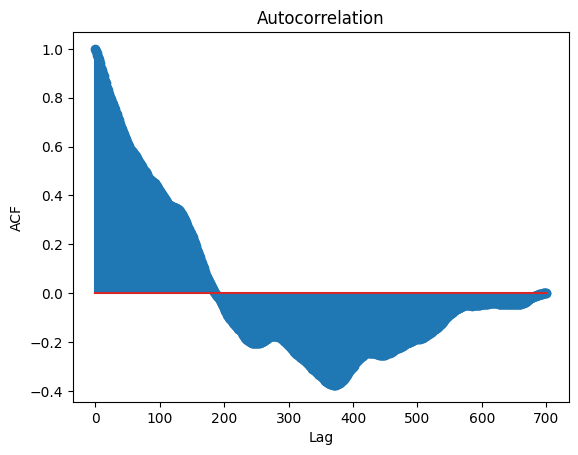

In [4]:
# 3. Tính toán ACF
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data['Price'], nlags= 700)

# Vẽ đồ thị ACF
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation')
plt.show()

In [5]:
# 4. Quá trình training
y_train = np.array(train_data['Price'])

x_train = []
for data in train_data['Low']:
  x_train.append([data])

model = dlm(y_train)
model = model + trend(1, discount=0.99, name='Trend', w=1e7)
model = model + dynamic(features=x_train, discount=1, name='Low')
model = model + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model = model + longSeason(period=12, stay=30, data=y_train, name='season', w=1e7)


model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [6]:
# 5. Quá trình testing
x_test= []
for data in test_data['Low']:
  x_test.append([data])

y_test = np.array(test_data['Price'])

y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'Low': x_test})
y_pred = y_pred[0]


In [7]:
# 6. Quá trình Validate
x_val= []
for data in val_data['Low']:
  x_val.append([data])

y_val = np.array(val_data['Price'])

y_pred_val = model.predictN(featureDict={'Low': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]


In [8]:
# 7. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 7303.531855756179
Testing RMSE: 9051.905263900824
Validation MAPE: 6.710044525426703
Testing MAPE: 7.1960934560033465
Validation MAE: 6940.473129977654
Testing MAE: 7849.78509968231


In [9]:
#  8. Sử dụng linear regression dự báo cột Low 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])


# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

index_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
low_next_30_days = ln_model.predict(index_next_30_days)

print(low_next_30_days)


[49646.55261921 49603.68913104 49560.82564287 49517.9621547
 49475.09866653 49432.23517836 49389.37169019 49346.50820202
 49303.64471385 49260.78122568 49217.91773751 49175.05424934
 49132.19076117 49089.327273   49046.46378483 49003.60029666
 48960.73680849 48917.87332032 48875.00983215 48832.14634398
 48789.28285581 48746.41936764 48703.55587947 48660.6923913
 48617.82890313 48574.96541496 48532.10192679 48489.23843862
 48446.37495046 48403.51146229]


In [10]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days = []
for data in low_next_30_days:
  x_next_30_days.append([data])

y_next_30_days = model.predictN(N = 30, featureDict={'Low': x_next_30_days})
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)


[61758.56891647885, 65790.07773667578, 65064.22055250614, 64040.48421517233, 64436.408991454315, 64290.668826583584, 64240.732861991084, 64248.942600268274, 64216.12424142297, 64196.917414669326, 64178.11889409676, 64157.01800352624, 64137.12662071161, 64117.01214478768, 64096.818374415365, 64076.70646480755, 64056.56582428244, 64036.42673536239, 64016.291776661994, 63996.154419603205, 63976.01763503357, 63955.88095826645, 63935.74412945071, 63915.60736264981, 63895.470589087694, 63875.33380865094, 63855.19703297878, 63835.06025597055, 63814.9234788611, 63794.78670203083]


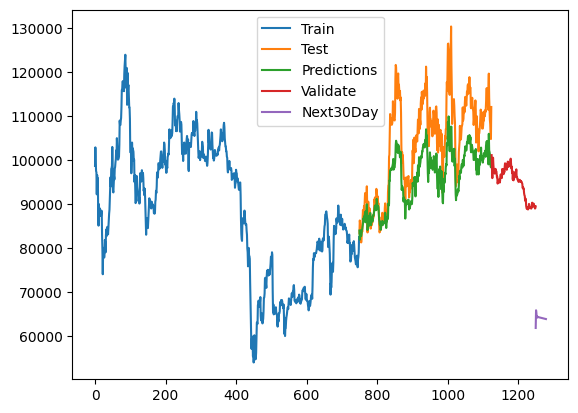

In [11]:
# 10. Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()